# Translation of empirics from R to python notebook

In [93]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pwlf

In [94]:
#Path:
#path = "C:/Users/wb555300/OneDrive - WBG/Documents/GitHub/My_COVID_19/"
path = "C:/Users/Stephan/Documents/GitHub/My_COVID_19/"
os.chdir(path)

Read current data from John Hopkins University - make sure to specify the correct path to the Covid-19 github here and keep the repository fork up to date:

In [95]:
#Path of the data repository:
#jhu_data_path = "C:/Users/wb555300/OneDrive - WBG/Documents/GitHub/COVID-19/"
jhu_data_path = "C:/Users/Stephan/Documents/GitHub/COVID-19/"

In [96]:
# Read confirmed cases:
dat_con_raw = pd.read_csv(jhu_data_path+"csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
#Read deaths:
dat_dea_raw = pd.read_csv(jhu_data_path+"csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
#Read recovered:
dat_rec_raw = pd.read_csv(jhu_data_path+"csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv")

Bring data into usable format:
- aggregate by country
- swap rows and columns
- create date column

In [97]:
dat_con = dat_con_raw.drop(columns = ['Province/State','Lat','Long']).groupby('Country/Region').sum().T
dat_dea = dat_dea_raw.drop(columns = ['Province/State','Lat','Long']).groupby('Country/Region').sum().T
dat_rec = dat_rec_raw.drop(columns = ['Province/State','Lat','Long']).groupby('Country/Region').sum().T

#Create date:
for x in [dat_con, dat_dea, dat_rec]:
    x['Date']=pd.to_datetime(x.index, format = '%m/%d/%y')

## Some overview plots

In [98]:
#Overview of available countries:
list(dat_con.columns)

['Afghanistan',
 'Albania',
 'Algeria',
 'Andorra',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Congo (Brazzaville)',
 'Congo (Kinshasa)',
 'Costa Rica',
 "Cote d'Ivoire",
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czechia',
 'Denmark',
 'Diamond Princess',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Fiji',
 'Finland',
 'France',
 'Gabon',
 'Gambia',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Grenada',
 'Guatemala',
 'Guinea',
 'Guyana',
 'Haiti',
 'Holy See',
 'Honduras',
 'Hungary',
 'Iceland',
 'In

In [99]:
countries = list(dat_con.columns[np.where(dat_con.iloc[-1,0:-1]>con_limit)])

In [101]:

fig = go.Figure()
fig = go.Figure()
for c in countries:
    fig.add_trace(go.Scatter(x=dat_con['Date'], y=dat_con[c],
                                  mode='lines',
                             name=c))
fig.update_layout(
    title="Development of COVID-19 cases in countries with more than " + str(con_limit) + " confirmed cases",
    xaxis_title="Date",
    yaxis_title="Confirmed cases")
    
fig.show()

fig.update_layout(yaxis_type="log",
                 yaxis_title="Confirmed cases (log scale)")
fig.show()

Look at single country and plot confirmed, recoeverd and deaths:

In [102]:
country = 'Japan'

fig = go.Figure()
fig = go.Figure()
names = ['Confirmed', 'Recoverd', 'Deaths']
for i, dat in enumerate([dat_con, dat_rec, dat_dea]):
    fig.add_trace(go.Scatter(x=dat['Date'], y=dat[country],
                                  mode='lines',
                             name=names[i]))
fig.update_layout(
    title="Development of COVID-19 cases in "+ country,
    xaxis_title="Date",
    yaxis_title="Cumulative count")
fig.show()

fig.update_layout(yaxis_type="log",
                 yaxis_title="Confirmed cases (log scale)")
fig.show()

## Endogenous breakpoint regressions:

Idea: 
- determine where the expoenential growth 'kicks' in
- run simple log linear regression to evealuate the growth rate

**tbc**

In [54]:
def breakpoint_reg_growth(country, n_breaks, plot = False):
    #Select x and y data:
    x = np.arange(0,len(dat_con),1)
    #y = np.log(dat_con[country])
    y = dat_con[country]
    # Remove missing values:
    #x = x[np.isfinite(y)]
    #y = y[np.isfinite(y)]
    x = x[y>0]
    y = np.log(y[y>0])
    
    
    #Generate piecewise linear fit:
        # fit the data for breaks line segments
        # this performs 5 multi-start optimizations
    my_pwlf = pwlf.PiecewiseLinFit(x, y)
    
    breaks = my_pwlf.fitfast(n_breaks, pop=5)
    
    #growth rate since last break
    current_growth = np.exp(my_pwlf.slopes[-1])-1
    
    res = {'Country': country, 'growth_period': list(dat_con.index[np.round(breaks).astype(int)[-2:]]),
           'last window': np.diff(np.round(breaks)[-2:]),
           'growth rate': current_growth}
    
    if plot == True:
        xHat = x
        yHat = my_pwlf.predict(xHat)
        plt.figure()
        plt.plot(x, y, 'o')
        plt.plot(xHat, yHat, '-')
        plt.title(country)    
        plt.show()
    
    return res
    

Result for Italy:

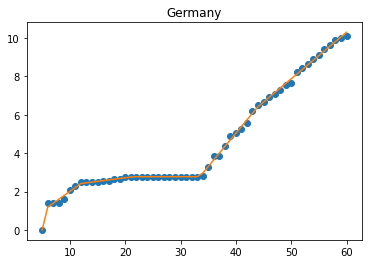

{'Country': 'Germany',
 'growth_period': ['3/6/20', '3/22/20'],
 'last window': array([16.]),
 'growth rate': 0.27448870806996095}

In [55]:
breakpoint_reg_growth('Germany', 6, plot = True)

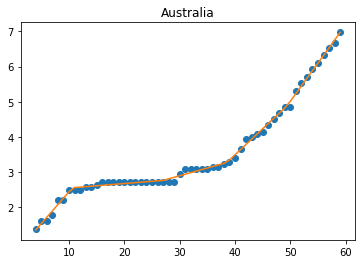

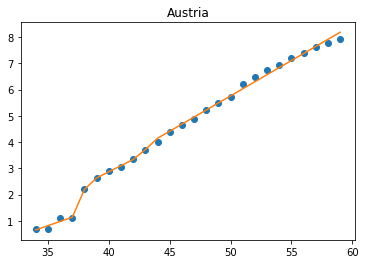

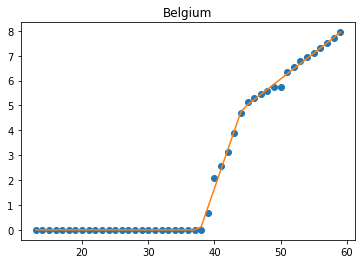

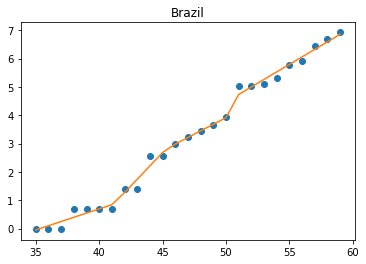

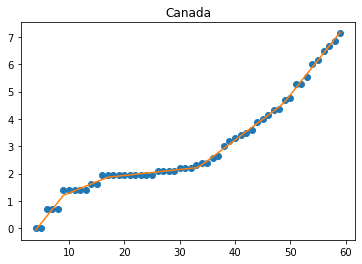

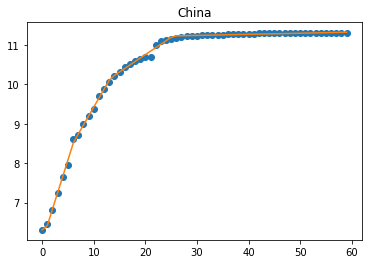

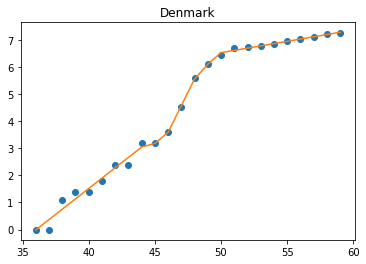

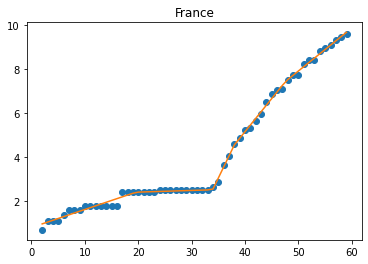

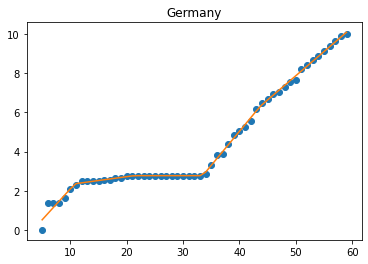

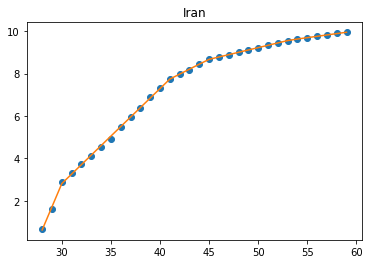

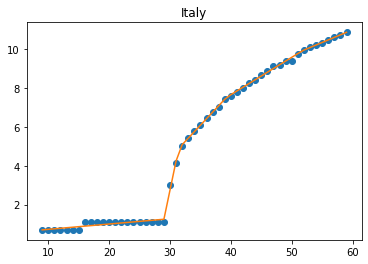

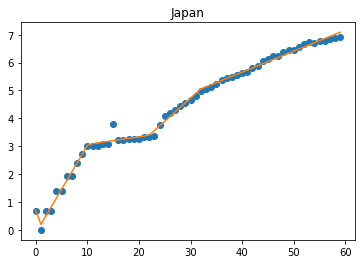

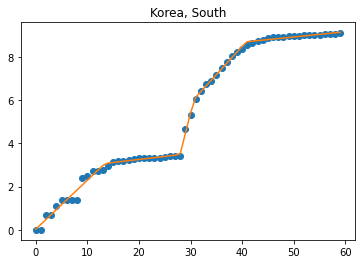

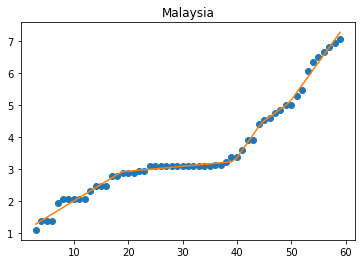

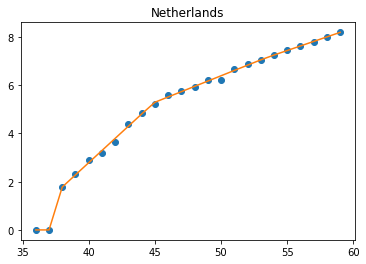

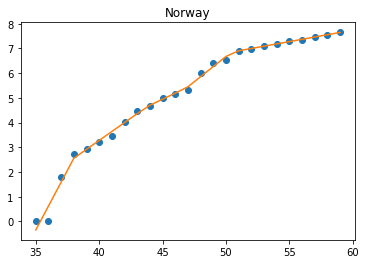

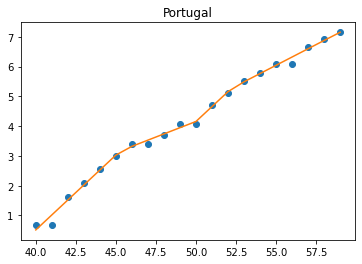

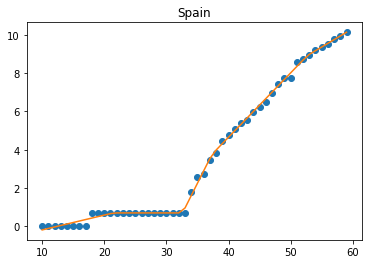

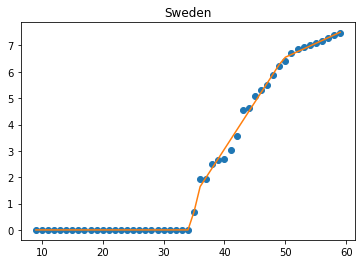

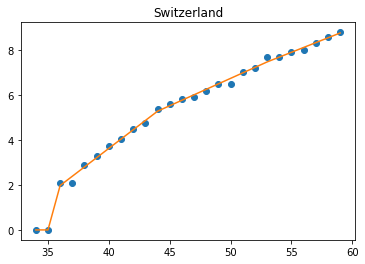

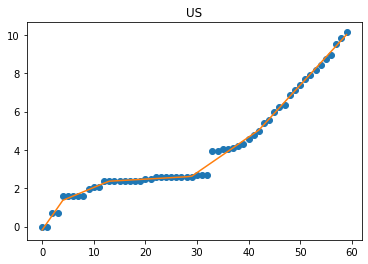

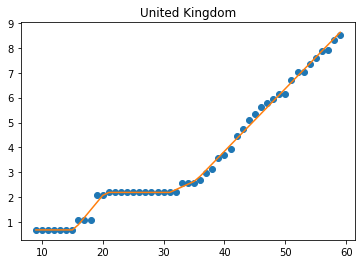

In [39]:
growth_rates = [breakpoint_reg_growth(c, 5, plot = True) for c in countries]

In [56]:
overview = pd.DataFrame(columns = ['Country', 'Growth Rate', 'Last Window'])

In [57]:
for x in growth_rates:
    overview = overview.append({'Country': x['Country'], 'Growth Rate': x['growth rate'], 'Last Window': x['last window']}, ignore_index=True)


In [58]:
fig = go.Figure()
fig.add_bar(x = overview['Country'], y = overview['Growth Rate'], hovertext = "Based on last" + overview['Last Window'].astype(str) +"days")
fig.show()